In [1]:
import collections
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from collections import Counter
from pathlib import Path
import logging

import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import json

# spacy for language processing
import spacy

# sklearn for feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# gensim for topic models
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus

# topic model viz
import pyLDAvis
from pyLDAvis.gensim_models import prepare
sns.set_style('white')

pyLDAvis.enable_notebook()

stop_words = set(pd.read_csv('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words',header=None,
                             squeeze=True).tolist())

In [2]:
# Helper Viz Functions
def show_word_list(model, corpus, top=10, save=False):
    top_topics = model.top_topics(corpus=corpus, coherence='u_mass', topn=20)
    words, probs = [], []
    for top_topic, _ in top_topics:
        words.append([t[1] for t in top_topic[:top]])
        probs.append([t[0] for t in top_topic[:top]])

    fig, ax = plt.subplots(figsize=(model.num_topics*1.2, 5))
    sns.heatmap(pd.DataFrame(probs).T, annot=pd.DataFrame(words).T, fmt='', ax=ax, cmap='Blues', cbar=False)
    fig.tight_layout()
    if save:
        fig.savefig(f'fin_news_wordlist_{top}', dpi=300)

def show_coherence(model, corpus, tokens, top=10, cutoff=0.01):
    top_topics = model.top_topics(corpus=corpus, coherence='u_mass', topn=20)
    word_lists = pd.DataFrame(model.get_topics().T, index=tokens)
    order = []
    for w, word_list in word_lists.items():
        target = set(word_list.nlargest(top).index)
        for t, (top_topic, _) in enumerate(top_topics):
            if target == set([t[1] for t in top_topic[:top]]):
                order.append(t)

    fig, axes = plt.subplots(ncols=2, figsize=(15,5))
    title = f'# Words with Probability > {cutoff:.2%}'
    (word_lists.loc[:, order]>cutoff).sum().reset_index(drop=True).plot.bar(title=title, ax=axes[1]);

    umass = model.top_topics(corpus=corpus, coherence='u_mass', topn=20)
    pd.Series([c[1] for c in umass]).plot.bar(title='Topic Coherence', ax=axes[0])
    fig.tight_layout()
    fig.savefig(f'fin_news_coherence_{top}', dpi=300);

def show_top_docs(model, corpus, docs):
    doc_topics = model.get_document_topics(corpus)
    df = pd.concat([pd.DataFrame(doc_topic, columns=['topicid', 'weight']).assign(doc=i)
                    for i, doc_topic in enumerate(doc_topics)])

    for topicid, data in df.groupby('topicid'):
        print(topicid, docs[int(data.sort_values('weight', ascending=False).iloc[0].doc)])
        print(pd.DataFrame(lda.show_topic(topicid=topicid)))

In [3]:
data_path = Path('data', 'us-financial-news')

section_titles = ['Press Releases - CNBC',
                  'Reuters: Company News',
                  'Reuters: World News',
                  'Reuters: Business News',
                  'Reuters: Financial Services and Real Estate',
                  'Top News and Analysis (pro)',
                  'Reuters: Top News',
                  'The Wall Street Journal &amp; Breaking News, Business, Financial and Economic News, World News and Video',
                  'Business &amp; Financial News, U.S &amp; International Breaking News | Reuters',
                  'Reuters: Money News',
                  'Reuters: Technology News']

In [4]:
def read_articles():
    articles = []
    counter = Counter()
    for f in data_path.glob('*/**/*.json'):
        article = json.load(f.open(encoding='UTF8'))
        if article['thread']['section_title'] in set(section_titles):
            text = article['text'].lower().split()
            counter.update(text)
            articles.append(' '.join([t for t in text if t not in stop_words]))
    return articles, counter

articles, counter = read_articles()
print(f'Done loading {len(articles):,.0f} articles')

Done loading 125,964 articles


In [5]:
most_common = (pd.DataFrame(counter.most_common(), columns=['token', 'count'])
               .pipe(lambda x: x[~x.token.str.lower().isin(stop_words)]))
most_common.head(10)

,token,count
8,$,592548
17,net,317060
18,),315742
23,million,269721
25,-,258943
26,income,257158
31,2018,227890
32,said,217339
33,%,214997
34,company,213316


In [6]:
# Preprocessing with SpaCy
results_path = Path('results', 'financial_news')
if not results_path.exists():
    results_path.mkdir(parents=True)
def clean_doc(d):
    doc = []
    for t in d:
        if not any([t.is_stop, t.is_digit, not t.is_alpha, t.is_punct, t.is_space, t.lemma_ == '-PRON-']):
            doc.append(t.lemma_)
    return ' '.join(doc)
nlp = spacy.load('en_core_web_sm')
nlp.max_length = 6000000
nlp.disable_pipes('ner')

D:\99.Dev\Anaconda\envs\ml4t\lib\site-packages\spacy\language.py:1035: DeprecationWarning: [W096] The method `nlp.disable_pipes` is now deprecated - use `nlp.select_pipes` instead.
  warnings.warn(Warnings.W096, DeprecationWarning)


['ner']

In [7]:
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer']

In [9]:
def preprocess(articles):
    iter_articles = (article for article in articles)
    clean_articles = []
    for i, doc in enumerate(nlp.pipe(iter_articles, batch_size=100, n_process=6), 1):
        if i % 1000 == 0:
            print(f'{i / len(articles):.2%}', end=' ', flush=True)
        clean_articles.append(clean_doc(doc))
    return clean_articles

clean_articles = preprocess(articles)

0.79% 1.59% 2.38% 3.18% 3.97% 4.76% 5.56% 6.35% 7.14% 7.94% 8.73% 9.53% 10.32% 11.11% 11.91% 12.70% 13.50% 14.29% 15.08% 15.88% 16.67% 17.47% 18.26% 19.05% 19.85% 20.64% 21.43% 22.23% 23.02% 23.82% 24.61% 25.40% 26.20% 26.99% 27.79% 28.58% 29.37% 30.17% 30.96% 31.76% 32.55% 33.34% 34.14% 34.93% 35.72% 36.52% 37.31% 38.11% 38.90% 39.69% 40.49% 41.28% 42.08% 42.87% 43.66% 44.46% 45.25% 46.04% 46.84% 47.63% 48.43% 49.22% 50.01% 50.81% 51.60% 52.40% 53.19% 53.98% 54.78% 55.57% 56.37% 57.16% 57.95% 58.75% 59.54% 60.33% 61.13% 61.92% 62.72% 63.51% 64.30% 65.10% 65.89% 66.69% 67.48% 68.27% 69.07% 69.86% 70.66% 71.45% 72.24% 73.04% 73.83% 74.62% 75.42% 76.21% 77.01% 77.80% 78.59% 79.39% 80.18% 80.98% 81.77% 82.56% 83.36% 84.15% 84.94% 85.74% 86.53% 87.33% 88.12% 88.91% 89.71% 90.50% 91.30% 92.09% 92.88% 93.68% 94.47% 95.27% 96.06% 96.85% 97.65% 98.44% 99.23% 

In [11]:
clean_path = results_path / 'clean_text'
clean_path.write_text('\n'.join(clean_articles), encoding='UTF8')

333796153

In [13]:
# Vectorize data
docs = clean_path.read_text(encoding='UTF8').split('\n')
len(docs)

125964

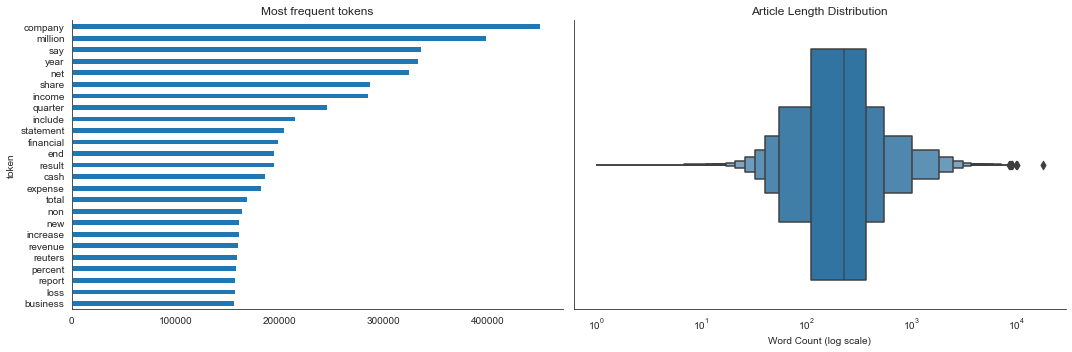

In [14]:
# Explore cleaned data
article_length, token_count = [], Counter()
for i, doc in enumerate(docs, 1):
    if i % 1e6 == 0:
        print(i, end=' ', flush=True)
    d = doc.lower().split()
    article_length.append(len(d))
    token_count.update(d)

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
(pd.DataFrame(token_count.most_common(), columns=['token', 'count'])
 .pipe(lambda x: x[~x.token.str.lower().isin(stop_words)]).set_index('token').squeeze().iloc[:25]
 .sort_values().plot.barh(ax=axes[0], title='Most frequent tokens'))
sns.boxenplot(x=pd.Series(article_length), ax=axes[1])
axes[1].set_xscale('log')
axes[1].set_xlabel('Word Count (log scale)')
axes[1].set_title('Article Length Distribution')
sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'fn_explore', dpi=300);

In [15]:
pd.Series(article_length).describe(percentiles=np.arange(.1, 1.0, .1))

D:\99.Dev\Anaconda\envs\ml4t\lib\site-packages\pandas\core\nanops.py:1682: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they. (Deprecated NumPy 1.22)
  return np.percentile(values, q, axis=axis, interpolation=interpolation)


count    125964.000000
mean        354.956924
std         535.260576
min           1.000000
10%          48.000000
20%          85.000000
30%         135.000000
40%         180.000000
50%         225.000000
60%         268.000000
70%         325.000000
80%         414.000000
90%         623.000000
max       17855.000000
dtype: float64

In [16]:
docs = [x.lower() for x in docs]
docs[3]

'want acheive success billionaire technology entrepreneur investor abc shark tank mark cuban advice challenge absorb new information life long learning probably great skill say arianna huffington thrive global podcast cuban avid reader espouse benefit scour book idea early career read technology industry help edge competitor guy little background compete far experienced guy time learn write blog read public buy book magazine information available want turn people want net worth billion today read recently cuban read copy principle life work ray dalio founder bridgewater associates dalio firm large hedge fund world manage billion chapter billionaire hedge fund founder ray dalio use radical transparency deliver feedback work et d sept principle dalio explain step step seek create culture brutal honesty bridgewater good idea rise book explain principle dalio employee follow include evaluate accurately kindly hide observation people cuban say book helpful learn start tweet book wish young 

In [17]:
# Set vocab parameters
min_df = .005
max_df = .1
ngram_range = (1, 1)
binary = False
vectorizer = TfidfVectorizer(stop_words='english', min_df=min_df, max_df=max_df, ngram_range=ngram_range,
                             binary=binary)
dtm = vectorizer.fit_transform(docs)
tokens = vectorizer.get_feature_names()
dtm.shape

(125964, 3722)

In [18]:
corpus = Sparse2Corpus(dtm, documents_columns=False)
id2word = pd.Series(tokens).to_dict()
dictionary = Dictionary.from_corpus(corpus, id2word)

# Train & Evaluate LDA Model
logging.basicConfig(filename='gensim.log', format="%(asctime)s:%(levelname)s:%(message)s", level=logging.DEBUG)
logging.root.level = logging.DEBUG

In [19]:
# Train models with 5-25 topics
num_topics = [5, 10, 15, 20]
for topics in num_topics:
    print(topics)
    lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=topics, chunksize=len(docs),
                     update_every=1,
                     alpha='auto',                     # a-priori belief for the each topics' probability
                     eta='auto',                       # a-priori belief on word probability
                     decay=0.5,                        # percentage of previous lambda value forgotten
                     offset=1.0, eval_every=1, passes=10, iterations=50, gamma_threshold=0.001,
                     minimum_probability=0.01,         # filter topics with lower probability
                     minimum_phi_value=0.01,           # lower bound on term probabilities
                     random_state=42)
    lda_model.save((results_path / f'model_{topics}').as_posix())

5
10
15
20


5
10
15
20


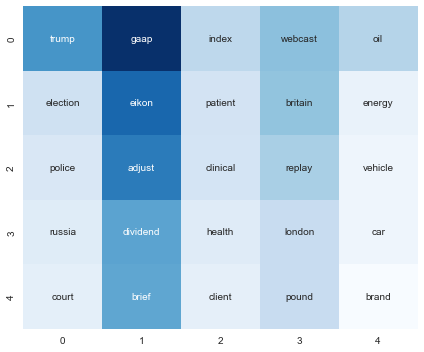

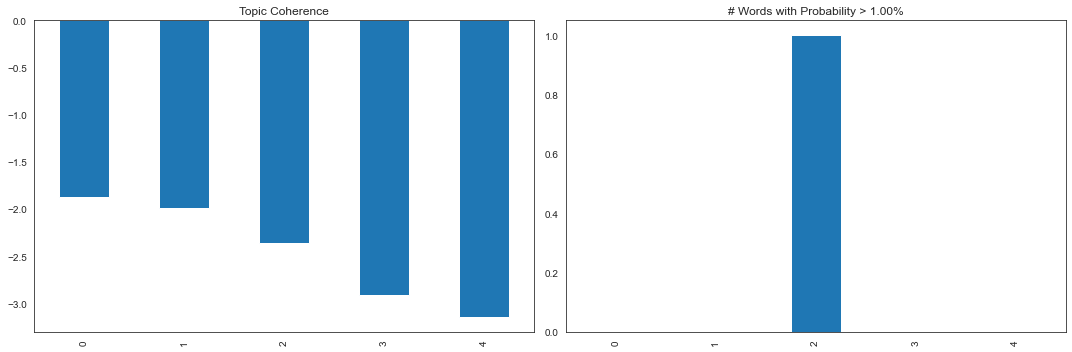

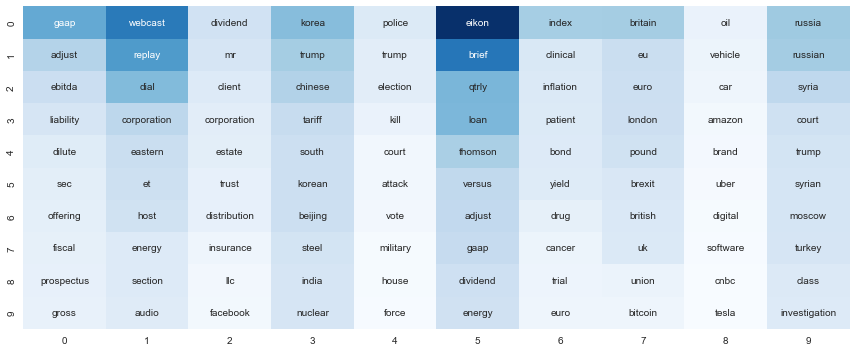

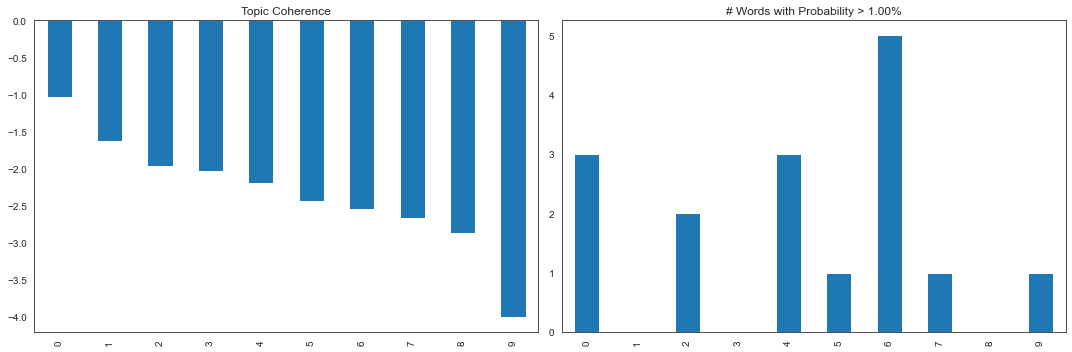

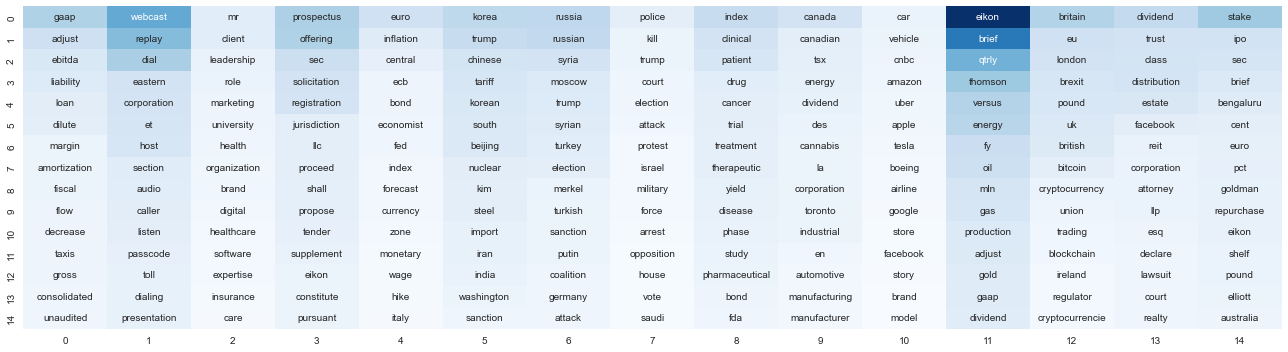

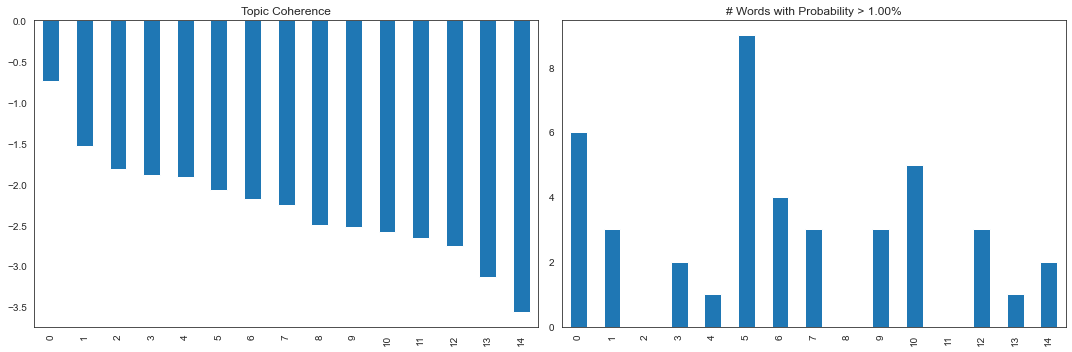

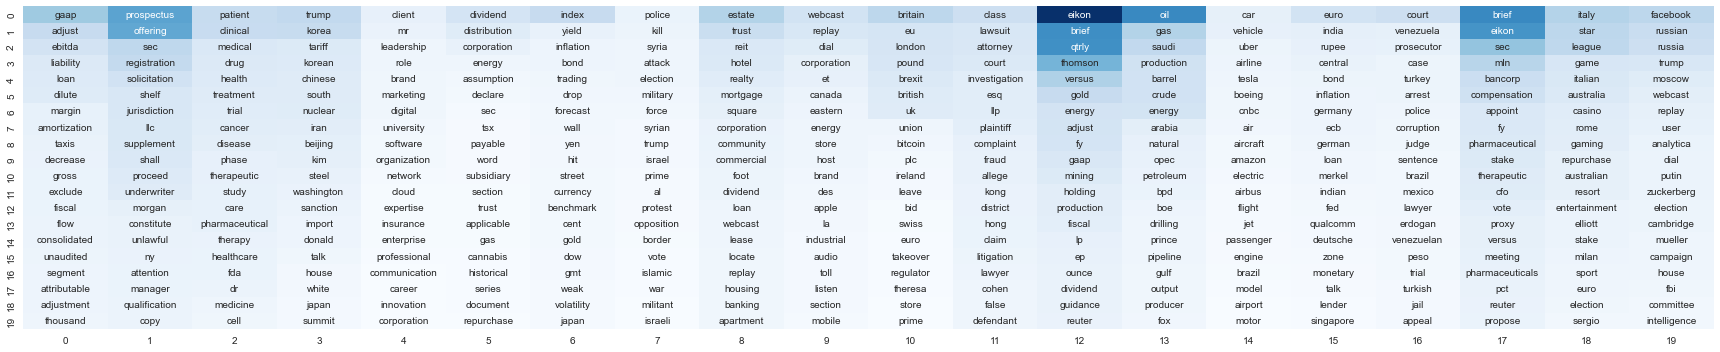

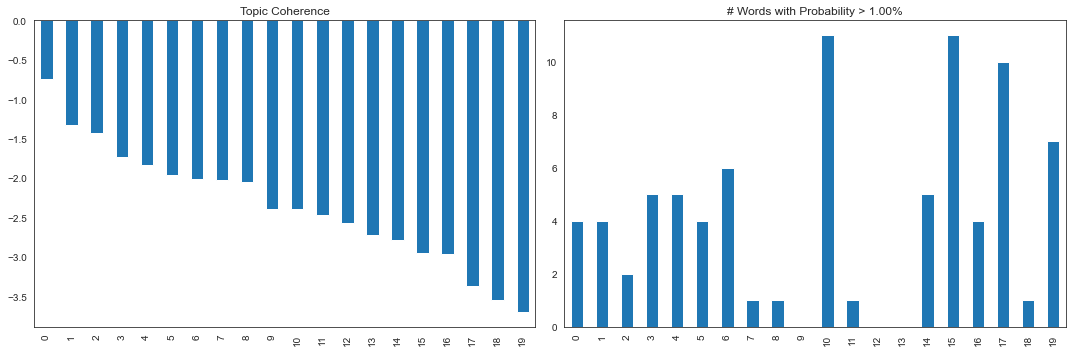

In [20]:
# Evaluate results
def eval_lda_model(ntopics, model, corpus=corpus, tokens=tokens):
    show_word_list(model=model, corpus=corpus, top=ntopics, save=True)
    show_coherence(model=model, corpus=corpus, tokens=tokens, top=ntopics)
    vis = prepare(model, corpus, dictionary, mds='tsne')
    pyLDAvis.save_html(vis, f'lda_{ntopics}.html')
    return 2 ** (-model.log_perplexity(corpus))

lda_models = {}
perplexity ={}
for ntopics in num_topics:
    print(ntopics)
    lda_models[ntopics] = LdaModel.load((results_path / f'model_{ntopics}').as_posix())
    perplexity[ntopics] = eval_lda_model(ntopics=ntopics, model=lda_models[ntopics])

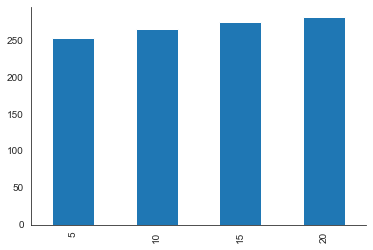

In [21]:
# Perplexity
pd.Series(perplexity).plot.bar()
sns.despine();

In [22]:
# PyLDAVis for 15 Topics
vis = prepare(lda_models[15], corpus, dictionary, mds='tsne')
pyLDAvis.display(vis)

In [24]:
# LDAMultiCore Timing
df = pd.read_csv(results_path / 'lda_multicore_test_results.csv')
df.head()

,workers,num_topics,duration,test_perplexity
0,1,10,2035.206371,72.621968
1,1,50,1611.578738,84.457663
2,4,10,1093.389884,72.742675
3,4,50,1067.982344,82.115884
4,8,10,1154.867700,72.791885


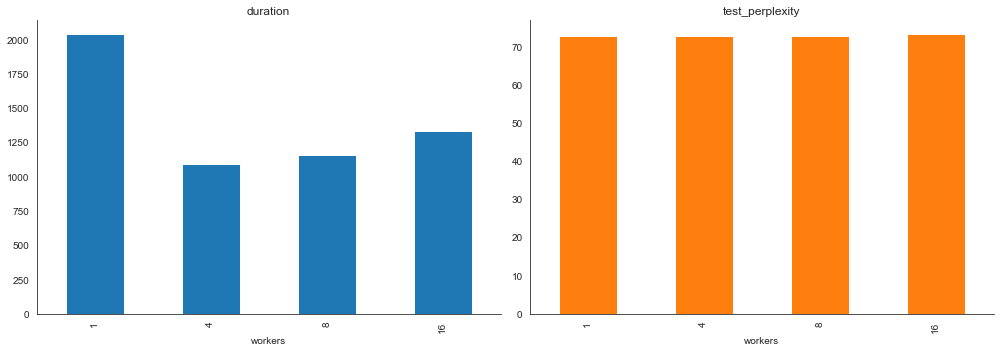

In [25]:
df[df.num_topics==10].set_index('workers')[['duration', 'test_perplexity']].plot.bar(subplots=True, layout=(1,2), figsize=(14,5), legend=False)
sns.despine()
plt.tight_layout();